In [29]:
import os
import pickle
import itertools
from datetime import datetime
from pprint import pprint

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

from sklearn.metrics import mean_absolute_error

os.chdir("C:/2023_11-PTSFC")
import model_train as model_train
import data_prepro as data_prepro
import model_eval as model_eval

In [2]:
import importlib
importlib.reload(model_eval)

<module 'model_eval' from 'C:\\2023_11-PTSFC\\model_eval.py'>

### Import

In [3]:
# os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # Replace "4" with the desired number of cores

quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
fcast_hor = [36, 40, 44, 60, 64, 68] # in hours

# = = = = = = = = = = = = = 
# get data
# df_energy = data_prepro.get_energy_data_today(to_date=t_wednesday.strftime('%Y%m%d'))

# Read data from file with specified data types
df_energy = pd.read_csv("data/2015-01-01_2024-02-21_energy.csv", index_col=0, parse_dates=[0])
df_energy['timestamp_CET'] = pd.to_datetime(df_energy['timestamp_CET'], utc=True).dt.tz_convert('CET')
print(df_energy.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80136 entries, 2014-12-31 23:00:00+00:00 to 2024-02-21 22:00:00+00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  80136 non-null  datetime64[ns, CET]
 1   gesamt         80136 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
None


In [4]:
# Read Pickle File of Scores
with open("2024-03-28_14-29-58 final all models/eval.pickle", "rb") as f:
    scores_dict = pickle.load(f)

# Read Pickle File of Fcasts
with open("2024-03-28_14-29-58 final all models/fcasts.pickle", "rb") as f:
    fcasts_dict = pickle.load(f)

### All Models Evaluation

In [5]:
input_dict = scores_dict
all_weekly_df_dict = {}

for week_key, weekly_scores in input_dict.items():

    weekly_scores_df_out = pd.DataFrame(index=list(input_dict[list(input_dict.keys())[0]].keys()),
                                    columns=['avg_qscore', 'avg_qscore_0.025', 'avg_qscore_0.25', 
                                             'avg_qscore_0.5', 'avg_qscore_0.75', 'avg_qscore_0.975'])

    for key, model_scores in weekly_scores.items():

        weekly_scores_df_out.loc[key, 'avg_qscore'] = model_scores.values.mean()
        weekly_scores_df_out.loc[key, 'avg_qscore_0.025'] = model_scores.mean(axis=0).iloc[0]
        weekly_scores_df_out.loc[key, 'avg_qscore_0.25'] = model_scores.mean(axis=0).iloc[1]
        weekly_scores_df_out.loc[key, 'avg_qscore_0.5'] = model_scores.mean(axis=0).iloc[2]
        weekly_scores_df_out.loc[key, 'avg_qscore_0.75'] = model_scores.mean(axis=0).iloc[3]
        weekly_scores_df_out.loc[key, 'avg_qscore_0.975'] = model_scores.mean(axis=0).iloc[4]
        
    all_weekly_df_dict[week_key] = weekly_scores_df_out

# sum all dataframes in dict (all_weekly_df_dict) and take mean
weekly_scores_df_out = pd.concat(all_weekly_df_dict.values())
weekly_scores_df_out = weekly_scores_df_out.groupby(weekly_scores_df_out.index).mean()
weekly_scores_df_out = weekly_scores_df_out.sort_values(by='avg_qscore', ascending=True)
# highlight min value in each col
display(weekly_scores_df_out.style.highlight_min(color = 'yellow', axis = 0))

,avg_qscore,avg_qscore_0.025,avg_qscore_0.25,avg_qscore_0.5,avg_qscore_0.75,avg_qscore_0.975,coverage_50,coverage_95,mae_q0.5
mstl_0.5,0.752816,0.187625,1.035197,1.311123,1.024416,0.205716,nan,nan,nan
mstl_1,0.800466,0.241344,1.084623,1.322330,1.110011,0.244023,nan,nan,nan
xgboost_dummy_2021,0.823620,0.188548,1.161153,1.415525,1.160698,0.192177,nan,nan,nan
xgboost_dummy_2020,0.828085,0.201534,1.168793,1.411545,1.174048,0.184506,nan,nan,nan
xgboost_dummy_2019,0.860353,0.218149,1.186562,1.479621,1.237002,0.180433,nan,nan,nan
lightgbm_dummy_2020,1.030033,1.120600,1.275643,1.328925,0.909611,0.515387,nan,nan,nan
bench_pm_1month,1.044384,0.295996,1.539142,1.878850,1.313894,0.194040,nan,nan,nan
grad_boost_2018_dummy,1.053459,0.409994,1.572649,1.762918,1.329238,0.192496,nan,nan,nan
lightgbm_dummy_2021,1.064932,1.092798,1.273182,1.341941,0.981200,0.635537,nan,nan,nan
grad_boost_2018_fturs,1.070209,0.461564,1.480261,1.859030,1.373439,0.176749,nan,nan,nan


### Ensemble Combination Eval Function ...

In [6]:
def eval_all_ensembles(ens_size, all_models, fcasts_dict_all):

    # Generate all possible combinations
    # ens_size = 1
    combis = list(itertools.combinations(all_models, ens_size))
    # filter out all ensembles with repeating models
    combis = [combi for combi in combis if len(set(combi)) == ens_size]
    print(len(combis))

    # Define the start and end dates
    start_date = pd.Timestamp('2023-11-15')
    end_date = pd.Timestamp('2024-02-14')

    # Generate a list of weekly dates in UTC
    fcast_dates_cet = pd.date_range(start=start_date, end=end_date, freq='W-WED').tz_localize('CET').strftime('%Y-%m-%d').tolist()

    if ens_size > 1 : all_combi_names = [f"ens | {', '.join(combi)}" for combi in combis]
    else : all_combi_names = [combi[0] for combi in combis]
    res_dict = {}

    # Iterate over the forecast dates
    for fcast_idx, fcast_date in enumerate(fcast_dates_cet):

        # print('= '*30)
        print(f"Forecasting for week starting from {fcast_date} ...")

        # = = = = = = = = = = = = = 
        # generate prediction timestamps based on t0 = following thursday 00:00
        # = = = = = = = = = = = = = 

        # Calculate the Thursday and Wednesday of the week
        t_wednesday = pd.Timestamp(fcast_date).replace(hour=0, minute=0, second=0, microsecond=0).tz_localize('CET')
        subm_timestamps = [(t_wednesday + pd.Timedelta(days=1, hours=fcast)) for fcast in fcast_hor]
        # print(f"Submission timestamps = {subm_timestamps[0]} to {subm_timestamps[-1]}")

        weekly_fcasts = fcasts_dict_all[fcast_date]

        # = = = = = = = = = = = = = 
        # Evaluation based on submission timestamps
        # = = = = = = = = = = = = = 

        # get actual values at every submission timestamp
        df_energy_eval = df_energy.loc[df_energy['timestamp_CET'].isin(subm_timestamps)].copy()

        weekly_scores_df = pd.DataFrame(index=all_combi_names,
                                        columns=['avg_qscore', 'avg_qscore_0.025', 'avg_qscore_0.25', 'avg_qscore_0.5', 'avg_qscore_0.75', 'avg_qscore_0.975',
                                                'coverage_50', 'coverage_95', 'mae_q0.5'])

        for combi_idx, combi in enumerate(combis):

            # calculate ensemble between the preds of the models in the current combination
            pred_list = [weekly_fcasts[model] for model in combi]
            new_name = f"ens | {', '.join(combi)}" if ens_size > 1 else combi[0]

            # Ignore timestamp_CET column and take the average of the quantiles
            pred_vals_list = [pred.iloc[:, 1:].copy() for pred in pred_list]

            # Take the average of the quantiles across all models in the ensemble
            ens_pred_df = pred_list[0].copy()
            ens_pred_df.iloc[:, 1:] = sum(pred_vals_list) / len(pred_vals_list)
            df_scores = model_eval.eval_fcast_qscore(ens_pred_df, df_energy_eval, subm_timestamps, quantiles)

            subm_df = ens_pred_df.loc[ens_pred_df['timestamp_CET'].isin(subm_timestamps)]
            # Save the last row of the scores dataframe to final output
            weekly_scores_df.loc[new_name, 'avg_qscore'] = df_scores.values.mean()
            weekly_scores_df.loc[new_name, 'avg_qscore_0.025'] = df_scores.mean(axis=0).iloc[0]
            weekly_scores_df.loc[new_name, 'avg_qscore_0.25'] = df_scores.mean(axis=0).iloc[1]
            weekly_scores_df.loc[new_name, 'avg_qscore_0.5'] = df_scores.mean(axis=0).iloc[2]
            weekly_scores_df.loc[new_name, 'avg_qscore_0.75'] = df_scores.mean(axis=0).iloc[3]
            weekly_scores_df.loc[new_name, 'avg_qscore_0.975'] = df_scores.mean(axis=0).iloc[4]
            weekly_scores_df.loc[new_name, 'coverage_50'] = df_energy_eval['gesamt'].between(subm_df.iloc[:, 2], subm_df.iloc[:, 4]).mean()
            weekly_scores_df.loc[new_name, 'coverage_95'] = df_energy_eval['gesamt'].between(subm_df.iloc[:, 1], subm_df.iloc[:, 5]).mean()
            weekly_scores_df.loc[new_name, 'mae_q0.5'] = mean_absolute_error(subm_df['q 0.500'], df_energy_eval['gesamt'])

        res_dict[fcast_date] = weekly_scores_df

    return res_dict


In [149]:
# calculate n choose k for variables n, k
import math
def nCk(n, k):
    return int(math.factorial(n) / (math.factorial(k) * math.factorial(n - k)))
print(nCk(19,2))
print(nCk(19,3))

171
969


### Single Models

In [93]:
all_models = list(fcasts_dict['2023-11-15'].keys())

# res_dict_1 = eval_all_ensembles(1, all_models, fcasts_dict)
res_df_1 = pd.concat(res_dict_1.values())
res_df_1 = res_df_1.groupby(res_df_1.index).mean() # .sort_values(by='avg_qscore', ascending=True)
# export to csv
# res_df_1.to_csv("2024_03_28 single model scores.csv")
display(res_df_1.style.highlight_min(color = 'yellow', axis=0))

,avg_qscore,avg_qscore_0.025,avg_qscore_0.25,avg_qscore_0.5,avg_qscore_0.75,avg_qscore_0.975,coverage_50,coverage_95,mae_q0.5
bench_pm_1month,2.088769,0.591992,3.078283,3.757699,2.627788,0.388081,0.404762,0.916667,3757.699405
bench_pm_2weeks,2.153455,0.827667,3.122549,3.726412,2.691222,0.399426,0.309524,0.821429,3726.412202
bench_same_month,2.290598,0.825176,3.521190,3.926381,2.778359,0.401884,0.392857,0.869048,3926.380952
grad_boost_2015_dummy,2.290344,0.938855,3.546806,3.965256,2.634196,0.366604,0.250000,0.726190,3965.256237
grad_boost_2015_fturs,2.369478,1.049068,3.618080,4.142479,2.672166,0.365597,0.238095,0.738095,4142.479486
grad_boost_2018_dummy,2.106918,0.819989,3.145298,3.525837,2.658475,0.384993,0.369048,0.750000,3525.836750
grad_boost_2018_fturs,2.140417,0.923129,2.960522,3.718060,2.746877,0.353497,0.357143,0.726190,3718.059621
lightgbm_dummy_2019,2.158338,2.391800,2.599369,2.773017,1.932464,1.095040,0.345238,0.345238,2773.016543
lightgbm_dummy_2020,2.060067,2.241200,2.551285,2.657850,1.819223,1.030774,0.357143,0.357143,2657.850474
lightgbm_dummy_2021,2.129863,2.185596,2.546364,2.683882,1.962399,1.271074,0.297619,0.297619,2683.882480


#### plot top single models

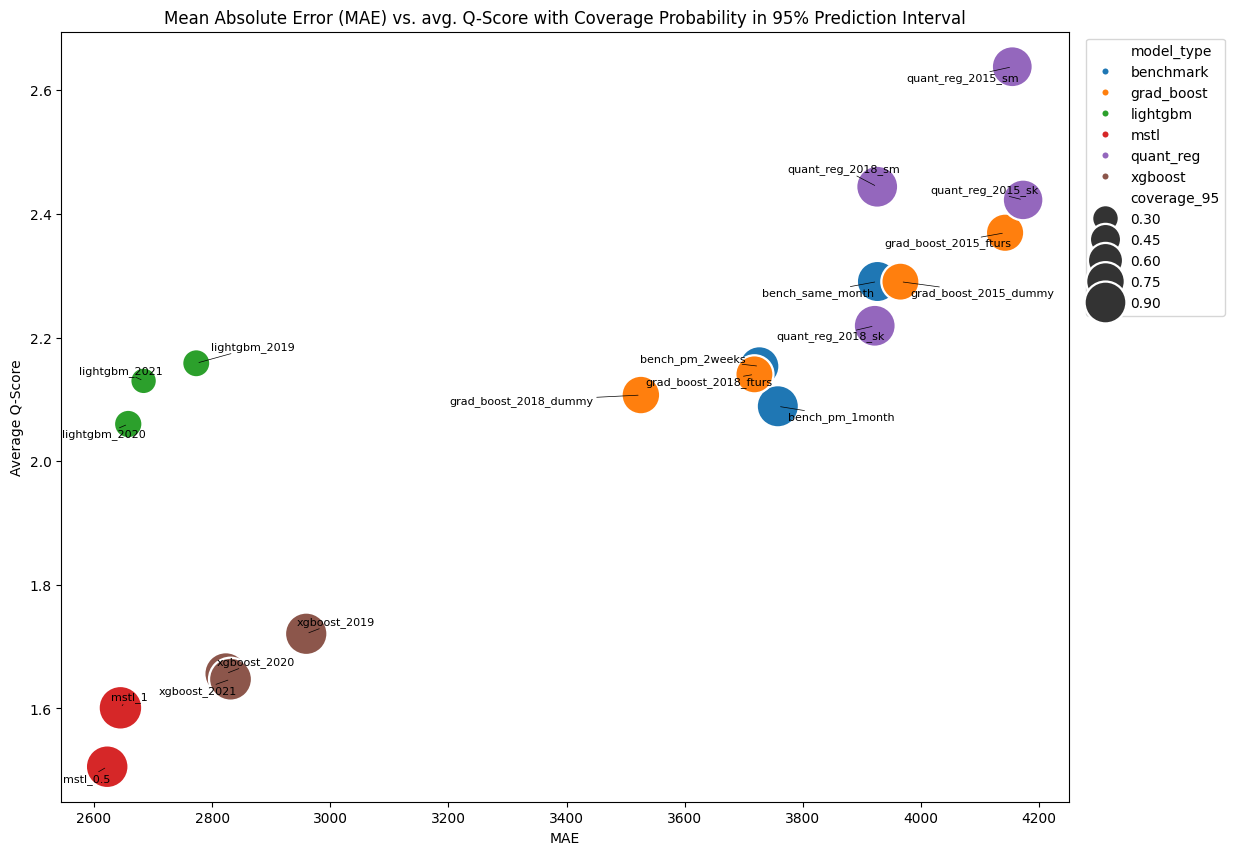

In [277]:
# Sample DataFrame (Replace this with your actual DataFrame)
df = res_df_1.copy()

# Remove "_dummy" from index of the dataframe
df.index = df.index.str.replace('lightgbm_dummy', 'lightgbm')
df.index = df.index.str.replace('xgboost_dummy', 'xgboost')

# Add model type as column
# benchmark, lightgbm, xgboost, quant_reg, grad_boost, mstl are the categories
df['model_type'] = 'benchmark'
df.loc[df.index.str.contains('lightgbm'), 'model_type'] = 'lightgbm'
df.loc[df.index.str.contains('xgboost'), 'model_type'] = 'xgboost'
df.loc[df.index.str.contains('quant_reg'), 'model_type'] = 'quant_reg'
df.loc[df.index.str.contains('grad_boost'), 'model_type'] = 'grad_boost'
df.loc[df.index.str.contains('mstl'), 'model_type'] = 'mstl'

# Bubble plot using Seaborn
plt.figure(figsize=(13, 10))
sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95', hue='model_type', 
                data=df, sizes=(100, 1000), size_norm=(0,1), legend='brief')

# Adding model names below the bubbles
texts = []
for model, row in df.iterrows():
    texts.append(plt.text(row['mae_q0.5'], row['avg_qscore'], model, 
                          ha='center', va='center', fontsize=8))
    
# Adjust text positions with increased space around text and points
adjust_text(texts, expand=(1.2,2), arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

# Customizing labels        
plt.xlabel('MAE')
plt.ylabel('Average Q-Score')
plt.title('Mean Absolute Error (MAE) vs. avg. Q-Score with Coverage Probability in 95% Prediction Interval')

# Placing legend outside the plot area on the top right
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.savefig('energy_1ens_1overview_bubble_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

### 2 Ensemble Combinations

In [278]:
# res_dict_2 = eval_all_ensembles(2, all_models, fcasts_dict)
res_df_2 = pd.concat(res_dict_2.values())
res_df_2.index = res_df_2.index.str.replace('ensemble', 'ens')
res_df_2 = res_df_2.groupby(res_df_2.index).mean().sort_values(by='avg_qscore', ascending=True)
# res_df.to_csv("2024_03_28 2 model ensemble scores.csv")
print(res_df_2.shape)
display(res_df_2.head(10).style.highlight_min(color = 'yellow', axis=0))

(171, 9)


,avg_qscore,avg_qscore_0.025,avg_qscore_0.25,avg_qscore_0.5,avg_qscore_0.75,avg_qscore_0.975,coverage_50,coverage_95,mae_q0.5
"ens | mstl_0.5, lightgbm_dummy_2021",1.065400,0.236046,1.351999,1.824637,1.563099,0.351217,0.595238,0.904762,1824.637449
"ens | mstl_0.5, lightgbm_dummy_2019",1.068598,0.224258,1.303860,1.826224,1.639066,0.349580,0.595238,0.904762,1826.224408
"ens | mstl_0.5, lightgbm_dummy_2020",1.073848,0.245904,1.375673,1.842524,1.576909,0.328228,0.583333,0.904762,1842.523729
"ens | mstl_1, lightgbm_dummy_2021",1.087932,0.276533,1.440663,1.820988,1.611548,0.289926,0.714286,0.964286,1820.987935
"ens | mstl_1, lightgbm_dummy_2020",1.106367,0.282800,1.473651,1.838925,1.645451,0.291006,0.678571,0.964286,1838.924805
"ens | mstl_1, lightgbm_dummy_2019",1.121404,0.268128,1.402305,1.829826,1.718235,0.293392,0.702381,0.964286,1824.589825
"ens | mstl_0.5, xgboost_dummy_2021",1.184771,0.347129,1.561319,1.857367,1.785821,0.372219,0.821429,1.000000,1857.366962
"ens | mstl_0.5, xgboost_dummy_2020",1.208198,0.338955,1.592028,1.931290,1.814166,0.364548,0.761905,1.000000,1931.290106
"ens | mstl_0.5, xgboost_dummy_2019",1.218048,0.328526,1.558411,1.960573,1.882256,0.360476,0.726190,1.000000,1960.573052
"ens | mstl_0.5, grad_boost_2018_dummy",1.250935,0.283446,1.481367,2.167046,1.965623,0.357195,0.559524,0.988095,2167.045750


#### plot all

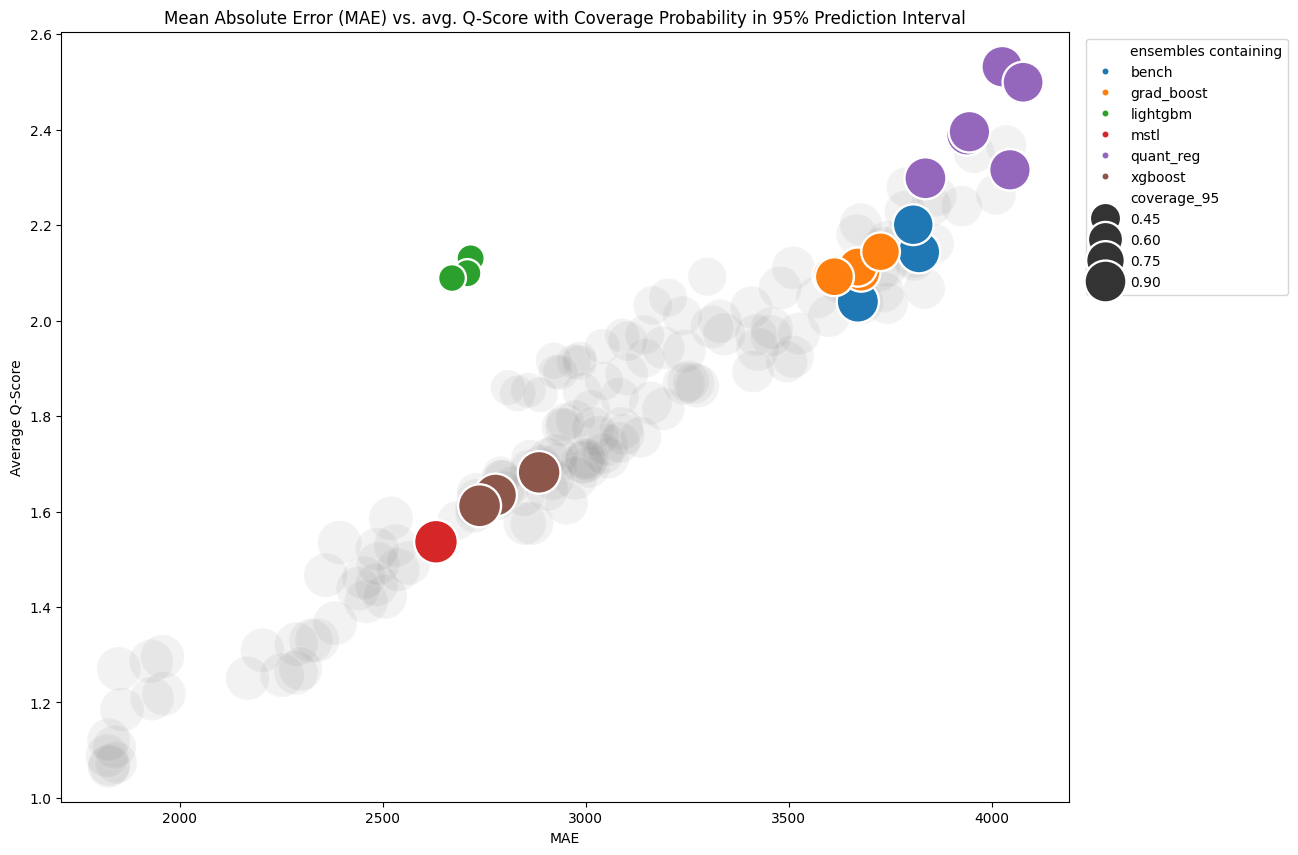

In [295]:
# overview of where single models are

# Sample DataFrame (Replace this with your actual DataFrame)
df = res_df_2.iloc[:10].copy()
df = res_df_2.copy()

# Remove "_dummy" from index of the dataframe
df.index = df.index.str.replace('lightgbm_dummy', 'lightgbm')
df.index = df.index.str.replace('xgboost_dummy', 'xgboost')

temp_name = '-'
# List of model types
model_types = ['bench', 'mstl', 'lightgbm', 'xgboost', 'grad_boost', 'quant_reg']
temp = [list(set([model_type for model_type in model_types if model_type in index])) for index in df.index]
df['ensembles containing'] = [item[0] if len(item)==1 else temp_name for item in temp]

# sort df alphabetically by model_type
df = df.sort_values(by='ensembles containing')

# # Define custom palette
# custom_palette = {temp_name: 'grey'}
custom_palette = {}
default_palette = sns.color_palette()
for idx, model_type in enumerate(sorted(model_types)):
    custom_palette[model_type] = default_palette[idx]

# Bubble plot using Seaborn for all non-grey dots
plt.figure(figsize=(13, 10))

# Plot grey dots separately with transparency
sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95',
                data=df[df['ensembles containing'] == temp_name], sizes=(100, 1000), size_norm=(0,1), 
                legend=False, color='grey', alpha=0.1)

sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95', hue='ensembles containing', 
                data=df[df['ensembles containing'] != temp_name], sizes=(100, 1000), size_norm=(0,1), 
                legend='brief', palette=custom_palette)

# Customizing labels
plt.xlabel('MAE')
plt.ylabel('Average Q-Score')
plt.title('Mean Absolute Error (MAE) vs. avg. Q-Score with Coverage Probability in 95% Prediction Interval')

# Placing legend outside the plot area on the top right
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.savefig('energy_2ens_1overview_bubble_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

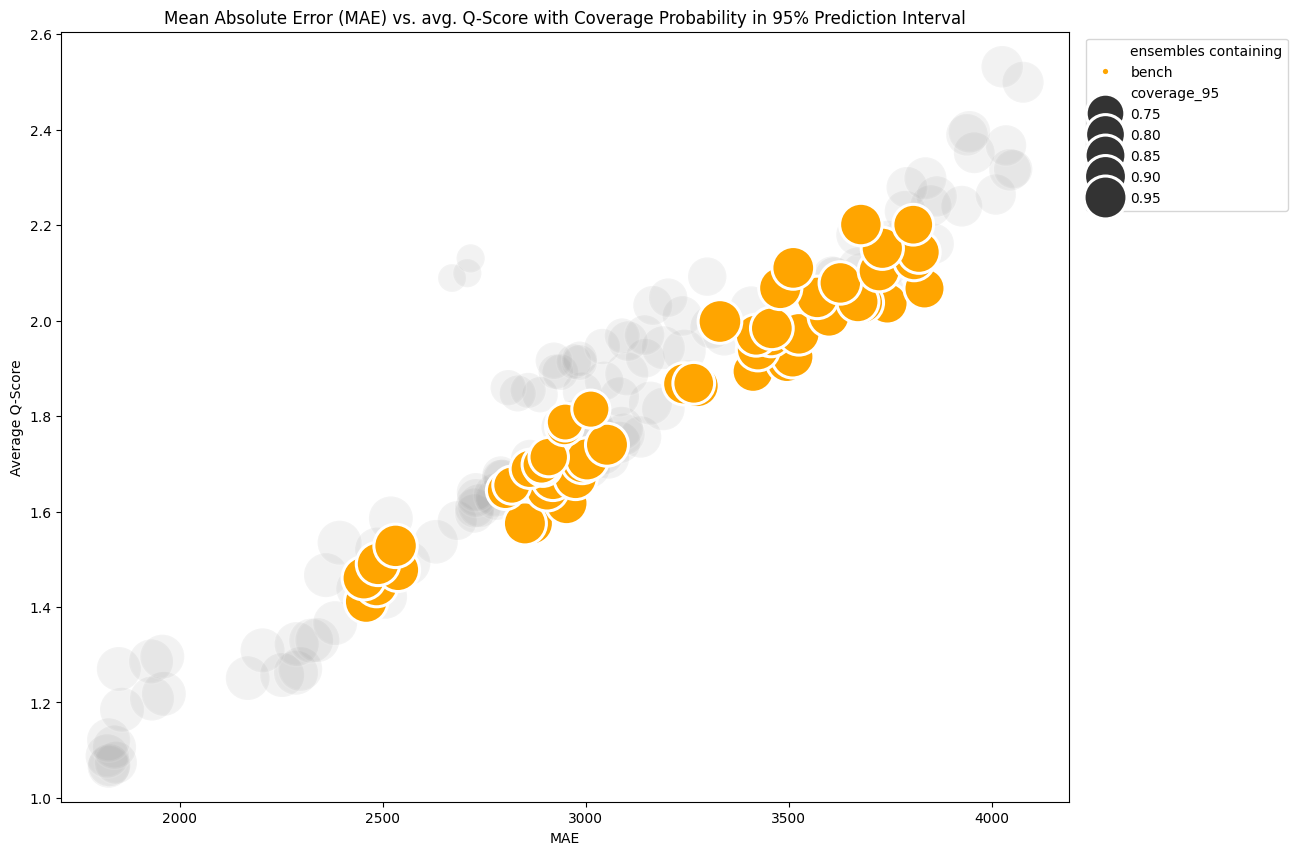

In [296]:
# Sample DataFrame (Replace this with your actual DataFrame)
df = res_df_2.iloc[:10].copy()
df = res_df_2.copy()

# Remove "_dummy" from index of the dataframe
df.index = df.index.str.replace('lightgbm_dummy', 'lightgbm')
df.index = df.index.str.replace('xgboost_dummy', 'xgboost')

# List of model types
model_types = ['bench', 'mstl', 'lightgbm', 'xgboost', 'grad_boost', 'quant_reg']

# Extract model types from index and create model type column
# df['model_type'] = [
#     ' + '.join([model_type for model_type in model_types if model_type in index]) if any(model_type in index for model_type in model_types)
#     else '-'
#     for index in df.index]

for idx, model_type in enumerate(model_types):

    df['ensembles containing'] = [f'{model_type}' if model_type in index else 'others' for index in df.index]
    
    # Define colors for contains_modeltype and others
    custom_palette = {f'{model_type}': 'orange'}

    # Bubble plot using Seaborn for all non-grey dots
    plt.figure(figsize=(13, 10))

    # Plot grey dots separately with transparency
    sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95',
                    data=df[df['ensembles containing'] != f'{model_type}'], sizes=(100, 1000), size_norm=(0,1), 
                    legend=False, color='grey', alpha=0.1)
    
    sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95', hue='ensembles containing', 
                data=df[df['ensembles containing'] == f'{model_type}'], sizes=(100, 1000), size_norm=(0,1), 
                legend='brief', palette=custom_palette)

    # Customizing labels        
    plt.xlabel('MAE')
    plt.ylabel('Average Q-Score')
    plt.title('Mean Absolute Error (MAE) vs. avg. Q-Score with Coverage Probability in 95% Prediction Interval')

    # Placing legend outside the plot area on the top right
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

    plt.savefig(f'energy_2ens_{model_type}_bubble_plot.pdf', dpi=300, bbox_inches='tight')
    if idx > 0: plt.close()
    else : plt.show()

#### plot top

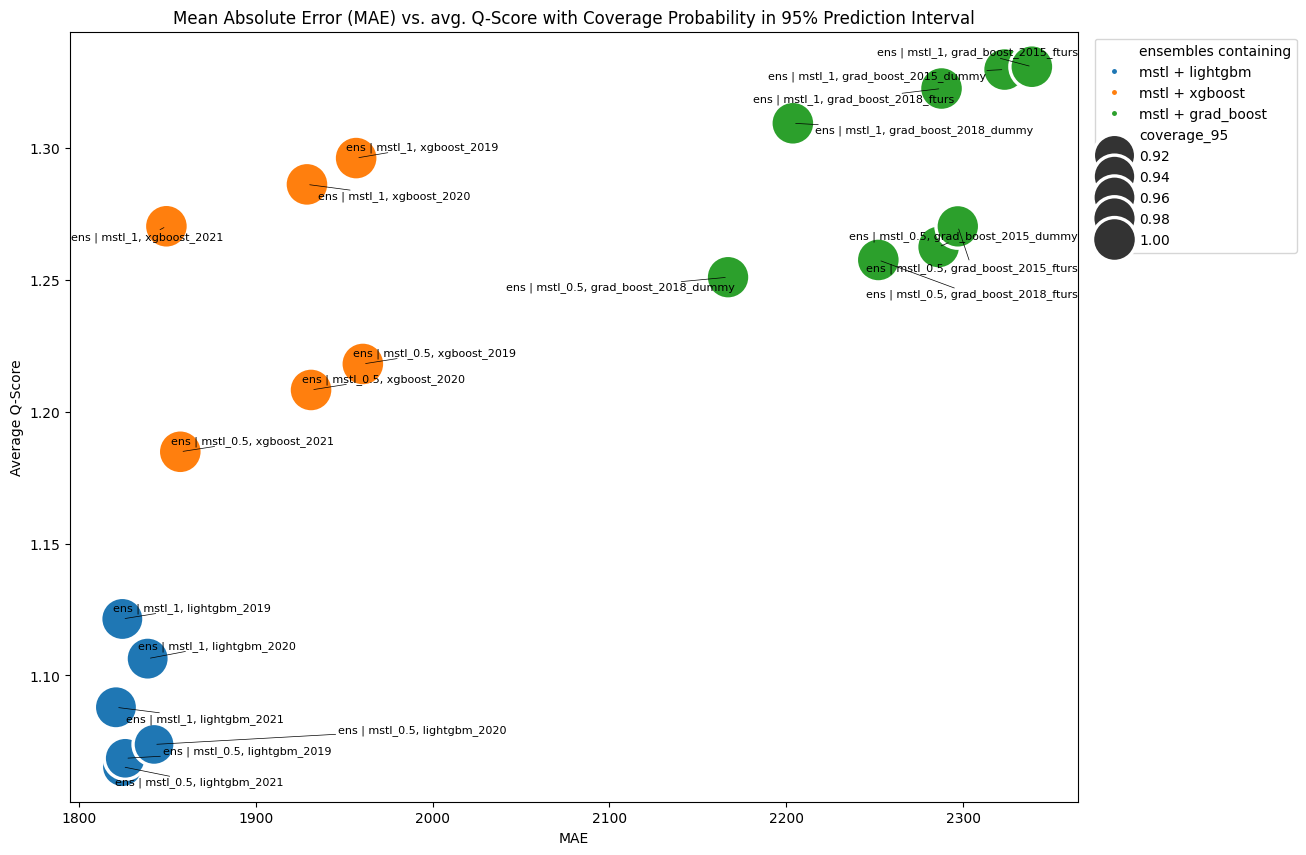

In [297]:
# Sample DataFrame (Replace this with your actual DataFrame)
df = res_df_2.iloc[:20].copy()

# Remove "_dummy" from index of the dataframe
df.index = df.index.str.replace('lightgbm_dummy', 'lightgbm')
df.index = df.index.str.replace('xgboost_dummy', 'xgboost')

# List of model types
model_types = ['bench', 'mstl', 'lightgbm', 'xgboost', 'grad_boost', 'quant_reg']

# Extract model types from index and create model type column
df['ensembles containing'] = [
    ' + '.join([model_type for model_type in model_types if model_type in index]) if any(model_type in index for model_type in model_types)
    else 'benchmark'
    for index in df.index]

# Bubble plot using Seaborn
plt.figure(figsize=(13, 10))
sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95', hue='ensembles containing', 
                data=df, sizes=(100, 1000), size_norm=(0,1), legend='brief')

# Adding model names below the bubbles
texts = []
for model, row in df.iterrows():
    texts.append(plt.text(row['mae_q0.5'], row['avg_qscore'], model, 
                          ha='center', va='center', fontsize=8))
    
# Adjust text positions with increased space around text and points
adjust_text(texts, expand=(1.2,2), arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

# Customizing labels        
plt.xlabel('MAE')
plt.ylabel('Average Q-Score')
plt.title('Mean Absolute Error (MAE) vs. avg. Q-Score with Coverage Probability in 95% Prediction Interval')

# Placing legend outside the plot area on the top right
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.savefig('energy_2ens_top10_bubble_plot_a.pdf', dpi=300, bbox_inches='tight')
plt.show()

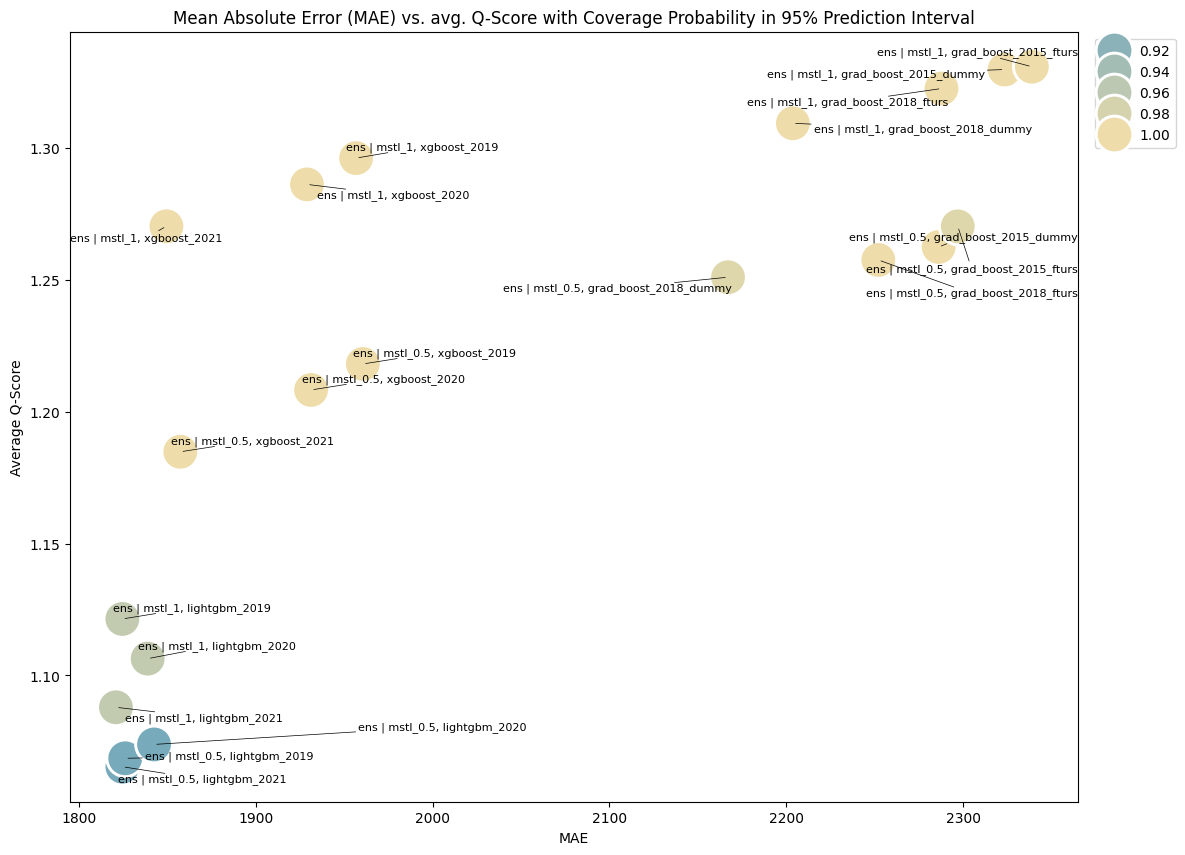

In [285]:
# Sample DataFrame (Replace this with your actual DataFrame)
df = res_df_2.iloc[:20].copy()

# Remove "_dummy" from index of the dataframe
df.index = df.index.str.replace('lightgbm_dummy', 'lightgbm')
df.index = df.index.str.replace('xgboost_dummy', 'xgboost')

# List of model types
model_types = ['bench', 'mstl', 'lightgbm', 'xgboost', 'grad_boost', 'quant_reg']

# Extract model types from index and create model type column
df['model_type'] = [
    ' + '.join([model_type for model_type in model_types if model_type in index]) if any(model_type in index for model_type in model_types)
    else 'benchmark'
    for index in df.index]

custom_palette = sns.color_palette("blend:#7AB,#EDA", as_cmap=True)

# Bubble plot using Seaborn
plt.figure(figsize=(13, 10))
sns.scatterplot(x='mae_q0.5', y='avg_qscore', hue='coverage_95', s=700,
                data=df, legend='brief', palette=custom_palette)

# tried to use different markers for different model types ...
# sns.scatterplot(x='mae_q0.5', y='avg_qscore', hue='coverage_95', style='model_type', s=700,
#                 data=df, legend='brief', palette=custom_palette, markers=markers_dict)

# Adding model names below the bubbles
texts = []
for model, row in df.iterrows():
    texts.append(plt.text(row['mae_q0.5'], row['avg_qscore'], model, 
                          ha='center', va='center', fontsize=8))
    
# Adjust text positions with increased space around text and points
adjust_text(texts, expand=(1.2,2), arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

# Customizing labels        
plt.xlabel('MAE')
plt.ylabel('Average Q-Score')
plt.title('Mean Absolute Error (MAE) vs. avg. Q-Score with Coverage Probability in 95% Prediction Interval')

# Placing legend outside the plot area on the top right
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.savefig('energy_2ens_top10_bubble_plot_b.pdf', dpi=300, bbox_inches='tight')
plt.show()

### custom ensembles ie 3+

In [286]:
def eval_custom_ensembles(ens_list, fcasts_dict_all):

    # Define the start and end dates
    start_date = pd.Timestamp('2023-11-15')
    end_date = pd.Timestamp('2024-02-14')

    # Generate a list of weekly dates in UTC
    fcast_dates_cet = pd.date_range(start=start_date, end=end_date, freq='W-WED').tz_localize('CET').strftime('%Y-%m-%d').tolist()
    all_combi_names = [f"ens | {', '.join(combi)}" if len(combi) > 1 else combi[0] for combi in ens_list]

    res_dict = {}

    # Iterate over the forecast dates
    for fcast_idx, fcast_date in enumerate(fcast_dates_cet):

        # print('= '*30)
        print(f"Forecasting for week starting from {fcast_date} ...")

        # = = = = = = = = = = = = = 
        # generate prediction timestamps based on t0 = following thursday 00:00
        # = = = = = = = = = = = = = 

        # Calculate the Thursday and Wednesday of the week
        t_wednesday = pd.Timestamp(fcast_date).replace(hour=0, minute=0, second=0, microsecond=0).tz_localize('CET')
        subm_timestamps = [(t_wednesday + pd.Timedelta(days=1, hours=fcast)) for fcast in fcast_hor]
        # print(f"Submission timestamps = {subm_timestamps[0]} to {subm_timestamps[-1]}")

        weekly_fcasts = fcasts_dict_all[fcast_date]

        # = = = = = = = = = = = = = 
        # Evaluation based on submission timestamps
        # = = = = = = = = = = = = = 

        # get actual values at every submission timestamp
        df_energy_eval = df_energy.loc[df_energy['timestamp_CET'].isin(subm_timestamps)].copy()

        weekly_scores_df = pd.DataFrame(index=all_combi_names,
                                        columns=['avg_qscore', 'avg_qscore_0.025', 'avg_qscore_0.25', 'avg_qscore_0.5', 'avg_qscore_0.75', 'avg_qscore_0.975',
                                                'coverage_50', 'coverage_95', 'mae_q0.5'])

        for combi_idx, combi in enumerate(ens_list):

            # calculate ensemble between the preds of the models in the current combination
            pred_list = [weekly_fcasts[model] for model in combi]
            new_name = f"ens | {', '.join(combi)}" if len(combi) > 1 else combi[0]

            # Ignore timestamp_CET column and take the average of the quantiles
            pred_vals_list = [pred.iloc[:, 1:].copy() for pred in pred_list]

            # Take the average of the quantiles across all models in the ensemble
            ens_pred_df = pred_list[0].copy()
            ens_pred_df.iloc[:, 1:] = sum(pred_vals_list) / len(pred_vals_list)
            df_scores = model_eval.eval_fcast_qscore(ens_pred_df, df_energy_eval, subm_timestamps, quantiles)

            subm_df = ens_pred_df.loc[ens_pred_df['timestamp_CET'].isin(subm_timestamps)]
            # Save the last row of the scores dataframe to final output
            weekly_scores_df.loc[new_name, 'avg_qscore'] = df_scores.values.mean()
            weekly_scores_df.loc[new_name, 'avg_qscore_0.025'] = df_scores.mean(axis=0).iloc[0]
            weekly_scores_df.loc[new_name, 'avg_qscore_0.25'] = df_scores.mean(axis=0).iloc[1]
            weekly_scores_df.loc[new_name, 'avg_qscore_0.5'] = df_scores.mean(axis=0).iloc[2]
            weekly_scores_df.loc[new_name, 'avg_qscore_0.75'] = df_scores.mean(axis=0).iloc[3]
            weekly_scores_df.loc[new_name, 'avg_qscore_0.975'] = df_scores.mean(axis=0).iloc[4]
            weekly_scores_df.loc[new_name, 'coverage_50'] = df_energy_eval['gesamt'].between(subm_df.iloc[:, 2], subm_df.iloc[:, 4]).mean()
            weekly_scores_df.loc[new_name, 'coverage_95'] = df_energy_eval['gesamt'].between(subm_df.iloc[:, 1], subm_df.iloc[:, 5]).mean()
            weekly_scores_df.loc[new_name, 'mae_q0.5'] = mean_absolute_error(subm_df['q 0.500'], df_energy_eval['gesamt'])

        res_dict[fcast_date] = weekly_scores_df

    return res_dict


In [287]:
model_lists = [['mstl_0.5', 'lightgbm_dummy_2021'], # top 2ensembles
               ['mstl_1', 'lightgbm_dummy_2021'],

               # top 3ensembles
               ['mstl_1', 'lightgbm_dummy_2019', 'lightgbm_dummy_2021'],
               ['mstl_1', 'lightgbm_dummy_2020', 'lightgbm_dummy_2021'],
               ['mstl_1', 'lightgbm_dummy_2019', 'lightgbm_dummy_2020'],

               ['mstl_0.5', 'lightgbm_dummy_2019', 'xgboost_dummy_2021'],
               ['mstl_0.5', 'lightgbm_dummy_2021', 'xgboost_dummy_2021'],
               ['mstl_0.5', 'mstl_1', 'lightgbm_dummy_2021'],

                # try 4/5 ensembles
               ['mstl_1', 'lightgbm_dummy_2019', 'lightgbm_dummy_2021', 'bench_pm_1month'],
               ['mstl_0.5', 'lightgbm_dummy_2019', 'lightgbm_dummy_2021', 'xgboost_dummy_2021', 'bench_pm_1month']]

res_dict_custom = eval_custom_ensembles(model_lists, fcasts_dict)

In [288]:
res_df_custom = pd.concat(res_dict_custom.values())
res_df_custom = res_df_custom.groupby(res_df_custom.index).mean().sort_values(by='avg_qscore', ascending=True)
# res_df_custom.to_csv("2024_03_28 custom ensemble scores.csv")
display(res_df_custom.style.highlight_min(color = 'yellow', axis=0))

,avg_qscore,avg_qscore_0.025,avg_qscore_0.25,avg_qscore_0.5,avg_qscore_0.75,avg_qscore_0.975,coverage_50,coverage_95,mae_q0.5
"ens | mstl_1, lightgbm_dummy_2021, lightgbm_dummy_2020",1.105083,0.276917,1.496957,1.919616,1.556510,0.275414,0.595238,0.892857,1919.616380
"ens | mstl_0.5, lightgbm_dummy_2021, xgboost_dummy_2021",1.116963,0.258475,1.476714,1.941253,1.625148,0.283223,0.630952,0.976190,1941.252699
"ens | mstl_0.5, mstl_1, lightgbm_dummy_2021, xgboost_dummy_2021",1.118740,0.302381,1.490293,1.827398,1.646303,0.327325,0.738095,1.000000,1827.398378
"ens | mstl_0.5, lightgbm_dummy_2021, lightgbm_dummy_2020",1.137565,0.313331,1.483655,1.924631,1.572408,0.393802,0.476190,0.833333,1924.630908
"ens | mstl_0.5, lightgbm_dummy_2021, xgboost_dummy_2020",1.149990,0.257490,1.525041,1.982291,1.708902,0.276225,0.630952,0.976190,1982.291306
"ens | mstl_0.5, lightgbm_dummy_2021, lightgbm_dummy_2019, xgboost_dummy_2021, bench_pm_1month",1.245311,0.273042,1.663634,2.248500,1.762160,0.279222,0.476190,0.952381,2248.499513


#### plot

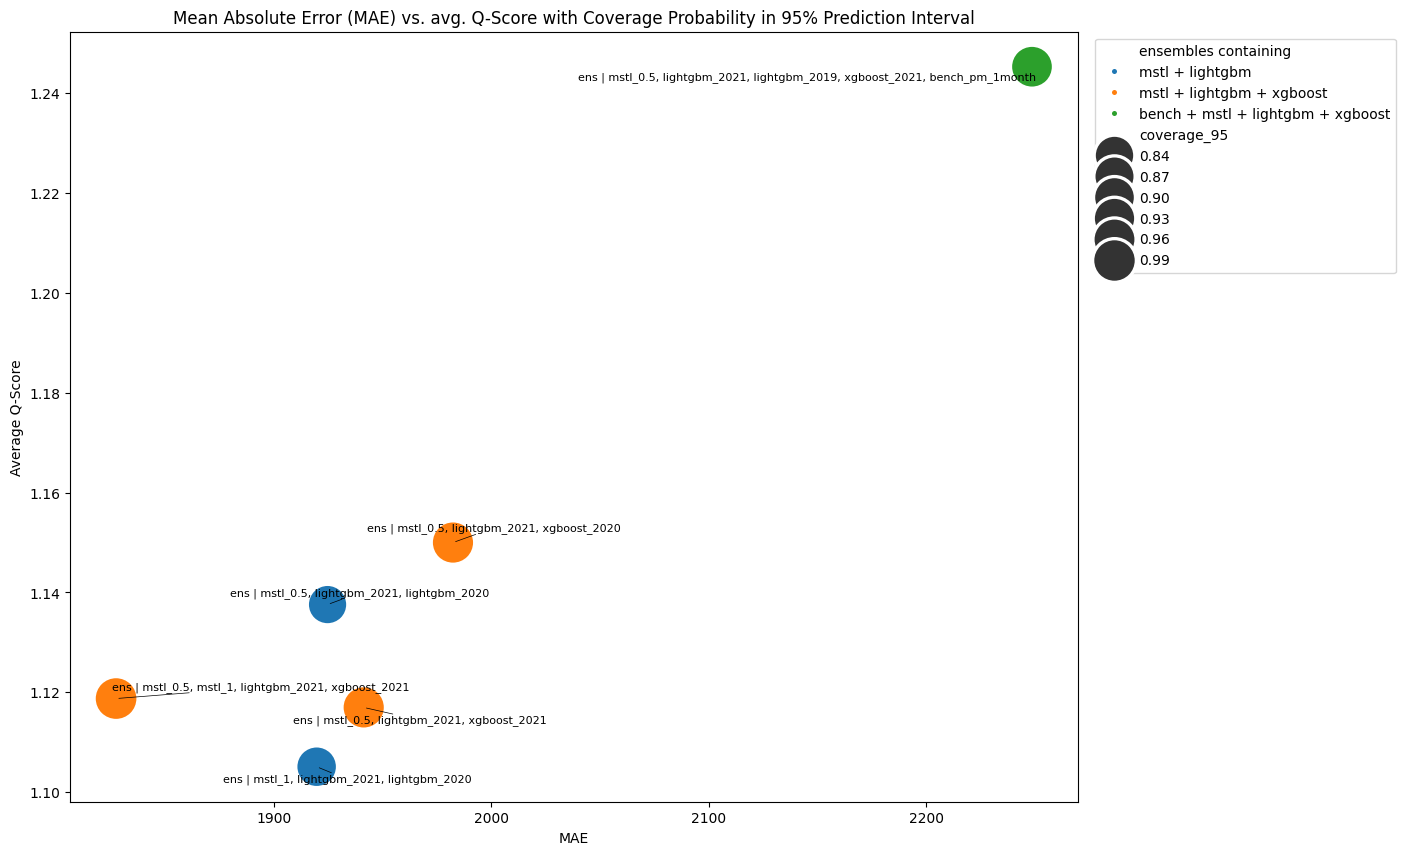

In [298]:
# Sample DataFrame (Replace this with your actual DataFrame)
df = res_df_custom.copy()

# Remove "_dummy" from index of the dataframe
df.index = df.index.str.replace('lightgbm_dummy', 'lightgbm')
df.index = df.index.str.replace('xgboost_dummy', 'xgboost')

# List of model types
model_types = ['bench', 'mstl', 'lightgbm', 'xgboost', 'grad_boost', 'quant_reg']

# Extract model types from index and create model type column
df['ensembles containing'] = [
    ' + '.join([model_type for model_type in model_types if model_type in index]) if any(model_type in index for model_type in model_types)
    else 'benchmark'
    for index in df.index]

# Bubble plot using Seaborn
plt.figure(figsize=(13, 10))
sns.scatterplot(x='mae_q0.5', y='avg_qscore', size='coverage_95', hue='ensembles containing', 
                data=df, sizes=(100, 1000), size_norm=(0,1), legend='brief')

# Adding model names below the bubbles
texts = []
for model, row in df.iterrows():
    texts.append(plt.text(row['mae_q0.5'], row['avg_qscore'], model, 
                          ha='center', va='center', fontsize=8))
    
# Adjust text positions with increased space around text and points
adjust_text(texts, expand=(1.2,2), arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

# Customizing labels        
plt.xlabel('MAE')
plt.ylabel('Average Q-Score')
plt.title('Mean Absolute Error (MAE) vs. avg. Q-Score with Coverage Probability in 95% Prediction Interval')

# Placing legend outside the plot area on the top right
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.savefig('energy_3ens_bubble_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()